In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import scipy.sparse as sp


import subprocess
import json
import tempfile
from transformers import RobertaTokenizer

from collections import defaultdict

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score
)
from tqdm import tqdm

device = torch.device("cpu")

In [13]:
def drop_node(feats, drop_rate,training=True,seed=42):
    """
    Args:
        feats (Tensor): 节点特征 [batch_size, num_nodes, feature_dim] 或 [num_nodes, feature_dim]
        drop_rate (float): 丢弃概率。

    Returns:
        Tensor: 丢弃后的节点特征，与输入形状一致。
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if not training or drop_rate <= 0.0:
        return feats
    if feats.dim() == 2:  # [num_nodes, feature_dim]
        num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((num_nodes,), drop_rate, device=feats.device, dtype=feats.dtype)  # [num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(1).expand(-1, feature_dim)  # [num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    elif feats.dim() == 3:  # [batch_size, num_nodes, feature_dim]
        batch_size, num_nodes, feature_dim = feats.shape
        drop_rates = torch.full((batch_size, num_nodes), drop_rate, device=feats.device, dtype=feats.dtype)  # [batch_size, num_nodes]
        if training:
            masks = torch.bernoulli(1. - drop_rates).unsqueeze(2).expand(-1, -1, feature_dim)  # [batch_size, num_nodes, feature_dim]
            feats = masks * feats
        else :
            feats = feats * (1. - drop_rate)
    else:
        raise ValueError(f"Unsupported feats dimension: {feats.dim()}")

    return feats


class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, input_dropout, hidden_dropout, batchnorm):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, out_dim)
        self.input_dropout = nn.Dropout(input_dropout)
        self.hidden_dropout = nn.Dropout(hidden_dropout)
        self.bn1 = nn.BatchNorm1d(in_dim) if batchnorm else None
        self.bn2 = nn.BatchNorm1d(hid_dim) if batchnorm else None

    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()

    def forward(self, x):
        if self.bn1:
            x = self.bn1(x)
        x = self.input_dropout(x)
        x = F.relu(self.layer1(x))
        if self.bn2:
            x = self.bn2(x)
        x = self.hidden_dropout(x)
        x = self.layer2(x)
        return x






class GGGNN(nn.Module):
    def __init__(self, feature_dim_size, hidden_size, num_GNN_layers, dropout, act=nn.functional.relu):
        super(GGGNN, self).__init__()
        self.num_GNN_layers = num_GNN_layers
        self.emb_encode = nn.Linear(feature_dim_size, hidden_size)
        self.dropout_encode = nn.Dropout(dropout)
        self.z0 = nn.Linear(hidden_size, hidden_size)
        self.z1 = nn.Linear(hidden_size, hidden_size)
        self.r0 = nn.Linear(hidden_size, hidden_size)
        self.r1 = nn.Linear(hidden_size, hidden_size)
        self.h0 = nn.Linear(hidden_size, hidden_size)
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.soft_att = nn.Linear(hidden_size, 1)
        self.ln = nn.Linear(hidden_size, hidden_size)
        self.act = act

    def gatedGNN(self, x, adj):
        a = torch.matmul(adj, x)
        # update gate
        z0 = self.z0(a)
        z1 = self.z1(x)
        z = torch.sigmoid(z0 + z1)
        # reset gate
        r = torch.sigmoid(self.r0(a) + self.r1(x))
        # update embeddings
        h = self.act(self.h0(a) + self.h1(r * x))

        return h * z + x * (1 - z)

    def forward(self, inputs, adj, mask):        # mask [B, N]
        x = self.dropout_encode(inputs)
        x = self.emb_encode(x)          # [B, N, H]
        mask_3d = mask.unsqueeze(-1)             # [B, N, 1]

        x = x * mask_3d                          # 广播到 [B, N, H]
        for _ in range(self.num_GNN_layers):
            x = self.gatedGNN(x, adj) * mask_3d  # 避免重复 unsqueeze
        return x

In [14]:
class GRAND_GatedFusion(nn.Module):
    def __init__(self,
                 in_dim,
                 hid_dim,
                 S=5,
                 K=3,
                 num_GNN_layers=2,
                 node_dropout=0.05,
                 input_droprate=0.1,
                 hidden_droprate=0.1,
                 batchnorm=False,
                 att_op='sum',
                 num_heads=8,
                 temp=0.5,
                 lam=1.0,
                 gnn_dropout=0.1,
                 args=None):
        super(GRAND_GatedFusion, self).__init__()
        self.S = S
        self.K = K
        self.args = args
        self.node_dropout_rate = node_dropout
        self.att_op = att_op
        self.temp = temp
        self.lam = lam
        
        # GRAND components
        self.grand_mlp = MLP(in_dim, hid_dim, hid_dim, input_droprate, hidden_droprate, batchnorm)
        
        # Gated GNN components
        self.gggnn = GGGNN(in_dim, hid_dim, num_GNN_layers, gnn_dropout)
        
        # Fusion gate parameters
        self.fusion_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.reset_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.update_gate = nn.Linear(2 * hid_dim, hid_dim)
        self.output_gate = nn.Linear(2 * hid_dim, hid_dim)
        
        # Output layer parameters
        if self.att_op == 'atten':
            self.att_fc = nn.Linear(hid_dim, 1)
            self.out_dim = hid_dim
        elif self.att_op == 'mul_head':
            self.att_fc = nn.Linear(hid_dim, num_heads)
            self.out_dim = hid_dim * num_heads
        elif self.att_op == 'concat':
            self.out_dim = 2 * hid_dim
        else:
            self.out_dim = hid_dim



    
    def normalize_adj(self, adj):
        if adj.dim() == 3:            # batched dense
            eye = torch.eye(adj.size(-1), device=adj.device)
            adj = adj + eye           # 加自环
            deg = adj.sum(-1)         # [B,N]
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)   # 避免除零
            # 利用广播而不是显式 diag，加速
            return deg_inv_sqrt.unsqueeze(-1) * adj * deg_inv_sqrt.unsqueeze(-2)


        elif adj.dim() == 2:
            N = adj.size(0)
            eye = torch.eye(N, device=adj.device, dtype=adj.dtype)
            adj = adj + eye
            deg = adj.sum(dim=1)                      
            deg_inv_sqrt = (deg + 1e-9).pow(-0.5)    
            return deg_inv_sqrt.unsqueeze(1) * adj * deg_inv_sqrt.unsqueeze(0)


        else:
            raise ValueError(f"Unsupported adj dimension: {adj.dim()}")

    def grand_conv(self, X, adj_norm):
        X_agg = X.clone()
        for _ in range(self.K):
            X = adj_norm @ X
            X_agg += X
        return X_agg / (self.K + 1)

    def gate_fusion(self, grand_feats, ggnn_feats):
        """Gated fusion mechanism combining GRAND and Gated GNN features"""
        combined = torch.cat([grand_feats, ggnn_feats], dim=-1)
        
        # Gating mechanisms
        reset = torch.sigmoid(self.reset_gate(combined))
        update = torch.sigmoid(self.update_gate(combined))
        
        # Intermediate fusion state
        intermediate = torch.tanh(self.fusion_gate(torch.cat([grand_feats, reset * ggnn_feats], dim=-1)))
        
        # Final fused output
        fused_output = update * ggnn_feats + (1 - update) * intermediate
        
        # Output gate
        output_gate = torch.sigmoid(self.output_gate(combined))
        return output_gate * fused_output + (1 - output_gate) * grand_feats

    def aggregate(self, x, mask=None):
        """Aggregate node features into graph-level embeddings"""
        x_sum = torch.sum(x, dim=1, keepdim=True)
        x_max = torch.amax(x, dim=1, keepdim=True)
        x_mean = torch.mean(x, dim=1, keepdim=True)
        
        if self.att_op == 'sum':
            return (x_sum + x_max).squeeze(1)
        elif self.att_op == 'max+mean':
            return (x_mean + x_max).squeeze(1)
        elif self.att_op == 'concat':
            return torch.cat((x_sum, x_max), dim=2).squeeze(1)
        elif self.att_op == 'atten':            # 单头注意力
            scores = self.att_fc(x).squeeze(-1)         # [B, N]
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)
            alpha = torch.softmax(scores, dim=1).unsqueeze(-1)
            return (alpha * x).sum(dim=1)
        elif self.att_op == 'mul_head':         # 多头注意力
            scores = self.att_fc(x)                       # [B, N, H]
            if mask is not None:
                scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)  
            alpha = torch.softmax(scores, dim=1)
            z_heads = (alpha.unsqueeze(-1) * x.unsqueeze(2)).sum(dim=1)
            return z_heads.reshape(x.size(0), -1)
        else:
            # multiply
            return (x_sum * x_max).squeeze(1)

    def forward(self, inputs, adj, mask=None, seed=None):
        inputs = inputs
        adj = adj
        mask = mask if mask is not None else None
        
        # Precompute Gated GNN features (only once)
        ggnn_feats = self.gggnn(inputs, adj, mask) if mask is not None else self.gggnn(inputs, adj, torch.ones_like(inputs[:, :, 0]))
        
        if self.training:
            emb_list = [] 
            enhanced_outputs = []
            adj_norm = self.normalize_adj(adj)
            
            for i in range(self.S):
                # GRAND feature propagation with node dropout
                grand_inputs = drop_node(inputs, self.node_dropout_rate, True, seed=int(int(seed)*10+i))
                grand_prop = torch.stack([self.grand_conv(grand_inputs[b], adj_norm[b]) for b in range(grand_inputs.size(0))])
                
                # Pass through GRAND's MLP
                grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
                grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
                
                # Gated fusion of GRAND and Gated GNN features
                fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
                
                # Apply mask if provided
                if mask is not None:
                    fused_feats = fused_feats * mask.unsqueeze(-1)
                
                # Aggregate to graph-level
                graph_emb = self.aggregate(fused_feats, mask)
                emb_list.append(graph_emb) 
                enhanced_outputs.append(graph_emb)
            
            # Compute consistency loss
            # ps = [torch.softmax(output, dim=-1) for output in enhanced_outputs]
            # avg_p = torch.mean(torch.stack(ps, dim=0), dim=0)
            # sharp_p = (torch.pow(avg_p, 1./self.temp) / 
            #           torch.sum(torch.pow(avg_p, 1./self.temp), dim=-1, keepdim=True)).detach()
            
            # consistency_loss = sum(torch.mean((p - sharp_p).pow(2).sum(dim=-1)) for p in ps) / len(ps)
            
            # Return mean graph embedding and consistency loss
            # return torch.mean(torch.stack(enhanced_outputs, dim=0), dim=0), consistency_loss

            return torch.stack(emb_list, dim=0), None
        
        
        else:  # Inference mode
            # GRAND feature propagation without dropout
            adj_norm = self.normalize_adj(adj)
            grand_prop = torch.stack([self.grand_conv(inputs[b], adj_norm[b]) for b in range(inputs.size(0))])
            
            # Pass through GRAND's MLP
            grand_mlp_out = self.grand_mlp(grand_prop.view(-1, grand_prop.size(-1)))
            grand_feats = grand_mlp_out.view(inputs.size(0), -1, grand_mlp_out.size(-1))
            
            # Gated fusion
            fused_feats = self.gate_fusion(grand_feats, ggnn_feats)
            
            # Apply mask if provided
            if mask is not None:
                fused_feats = fused_feats * mask.unsqueeze(-1)
            
            # Aggregate to graph-level
            graph_emb = self.aggregate(fused_feats, mask)
            return graph_emb, None


In [15]:
import torch.nn as nn, torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, base_cfg, num_classes):
        super().__init__()
        self.encoder = GRAND_GatedFusion(**base_cfg).float()
        self.classifier = nn.Linear(self.encoder.out_dim, num_classes)
        # self.classifier = nn.Linear(base_cfg['hid_dim']*base_cfg['num_heads'],  # out_dim
        #                             num_classes)

    def forward(self, x, adj, mask, seed=None, train_consistency=True):
        if self.training and train_consistency:
            # ---------- (1) 取 [S, B, D] ----------
            emb_stack, _ = self.encoder(x, adj, mask, seed=seed)

            # ---------- (2) 得到 [S, B, C] ----------
            logits_stack = self.classifier(emb_stack)

            # ---------- (3) 计算 Sharpen consistency ----------
            ps = torch.softmax(logits_stack, dim=-1)       # [S,B,C]
            avg_p = ps.mean(dim=0)                         # [B,C]

            temp = self.encoder.temp                       # 与 cfg 保持一致
            sharp_p = (avg_p.pow(1. / temp) /
                    avg_p.pow(1. / temp).sum(dim=-1, keepdim=True)).detach()

            consistency = ((ps - sharp_p) ** 2).sum(-1).mean()

            # ---------- (4) 把 S 个 logits 取平均做分类 ----------
            logits = logits_stack.mean(dim=0)              # [B,C]

        else:                                              # Eval 或关闭一致性
            emb, _ = self.encoder(x, adj, mask)
            logits = self.classifier(emb)
            consistency = torch.tensor(0., device=logits.device)

        return logits, consistency


In [16]:

import json, re, os, random

from dataclasses import dataclass
from typing import List
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import (AdamW, RobertaForSequenceClassification, AutoTokenizer)
# Jupyter Cell 2
def clean_code(code: str) -> str:
    """去单/多行注释 + 空行"""
    code = re.sub(r"//.*?$",     "", code, flags=re.MULTILINE)
    code = re.sub(r"/\*.*?\*/",  "", code, flags=re.DOTALL)
    code = re.sub(r"^\s*$\n?",   "", code, flags=re.MULTILINE)
    return code.strip()

@dataclass
class InputFeatures:
    input_ids:  List[int]
    attention_mask: List[int]
    label: int

def convert_example(js, tokenizer, block_size):
    code = ' '.join(clean_code(js['func']).split())
    tokens = tokenizer.tokenize(code)[: block_size - 2]
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    attn_mask = [1] * len(input_ids)

    pad_len = block_size - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * pad_len
    attn_mask += [0] * pad_len

    return InputFeatures(
        input_ids      = input_ids,
        attention_mask = attn_mask,
        label          = int(js['target'])
    )
%env http_proxy=http://10.254.25.18:7890
%env https_proxy=http://10.254.25.18:7890

%env TOKENIZERS_PARALLELISM=false


env: http_proxy=http://10.254.25.18:7890
env: https_proxy=http://10.254.25.18:7890
env: TOKENIZERS_PARALLELISM=false


In [17]:
tokenizer =  RobertaTokenizer.from_pretrained('microsoft/graphcodebert-base')


att_op_dict = {
    'sum': 'sum',
    'mul': 'mul',
    'concat': 'concat'
}



weighted_graph = False
print('using default unweighted graph')

TF_IDF = True
PMI =True


from collections import Counter

def collect_global_stats(shuffle_doc_words_list, window_size=3):
    token_freq  = Counter()      # P(w)
    pair_freq   = Counter()      # P(w_i, w_j) 共现
    total_windows = 0

    for doc in shuffle_doc_words_list:
        end = len(doc)
        while end > 0 and doc[end-1] in {1, 2}:
            end -= 1
        doc = doc[:end]

        # 更新 token 出现次数
        token_freq.update(doc)

        # 遍历窗口统计共现
        if len(doc) <= window_size:
            windows = [doc]
        else:
            windows = [doc[i:i+window_size] for i in range(len(doc)-window_size+1)]

        for win in windows:
            total_windows += 1
            for i in range(1, len(win)):
                for j in range(0, i):
                    u, v = win[i], win[j]
                    if u == v: 
                        continue
                    pair_freq[(u, v)] += 1
                    pair_freq[(v, u)] += 1   # 无向
    return token_freq, pair_freq, total_windows






def build_graph(shuffle_doc_words_list, word_embeddings, window_size=3, weighted_graph=True,TF_IDF=False, PMI=False):
    if TF_IDF:
        token_freq, pair_freq, W = collect_global_stats(shuffle_doc_words_list, window_size=window_size)
        def pmi(u, v, W, eps=1e-9):
            # 频数 → 概率
            p_uv = pair_freq[(u, v)] / W
            p_u  = token_freq[u] / W
            p_v  = token_freq[v] / W
            val = np.log((p_uv + eps) / (p_u * p_v + eps))
            return max(val, 0.)          # 常见做法：负 PMI 设 0（稀疏化）
        

    x_adj = []
    x_feature = []
    doc_len_list = []
    vocab_set = set()

    # 确保 word_embeddings 是 NumPy 数组
    if isinstance(word_embeddings, torch.Tensor):
        embeddings_np = word_embeddings.cpu().numpy()
    else:
        embeddings_np = word_embeddings

    for i in range(len(shuffle_doc_words_list)):
        doc_words = shuffle_doc_words_list[i]
        end = len(doc_words)
        while end > 0 and doc_words[end-1] in {1, 2}:  # 移除padding
            end -= 1
        doc_words = doc_words[:end]
        doc_len = len(doc_words)

        # 获取token字符串表示
        tokens_str = tokenizer.convert_ids_to_tokens(doc_words)
        
        doc_vocab = list(set(doc_words))
        doc_nodes = len(doc_vocab)

        doc_len_list.append(doc_nodes)
        vocab_set.update(doc_vocab)

        doc_word_id_map = {}
        for j in range(doc_nodes):
            doc_word_id_map[doc_vocab[j]] = j

        # 使用defaultdict简化边计数
        word_pair_count = defaultdict(float)

        # 1. 添加滑动窗口共现边
        windows = []
        if doc_len <= window_size:
            windows.append(doc_words)
        else:
            for j in range(doc_len - window_size + 1):
                window = doc_words[j: j + window_size]
                windows.append(window)

        for window in windows:
            for p in range(1, len(window)):
                for q in range(0, p):
                    word_p_id = window[p]
                    word_q_id = window[q]
                    if word_p_id == word_q_id:
                        continue
                    # 共现边（双向添加）
                    word_pair_count[(word_p_id, word_q_id)] += 1.0
                    word_pair_count[(word_q_id, word_p_id)] += 1.0

        # 2. 添加基本的数据流边（基于常见代码模式）
        for pos in range(1, doc_len):
            current_token = doc_words[pos]
            prev_token = doc_words[pos-1]
            current_token_str = tokens_str[pos]
            
            # 模式1: 赋值语句 (a = b)
            # 处理带空格的等号 (Ġ=) 和普通等号 (=)
            if current_token_str in ["=", "Ġ="] and pos > 0 and pos < doc_len - 1:
                # 连接左侧变量和右侧表达式
                if pos >= 1 and pos < doc_len - 1:
                    left_var = doc_words[pos-1]
                    right_expr = doc_words[pos+1]
                    word_pair_count[(left_var, right_expr)] += 2.0
                    word_pair_count[(right_expr, left_var)] += 2.0
            
            # 模式2: 方法调用 (obj.method())
            # 处理带空格的点 (Ġ.) 和普通点 (.)
            if current_token_str in [".", "Ġ."] and pos > 0 and pos < doc_len - 1:
                # 连接对象和方法名
                if pos >= 1 and pos < doc_len - 1:
                    obj = doc_words[pos-1]
                    method = doc_words[pos+1]
                    word_pair_count[(obj, method)] += 1.5
                    word_pair_count[(method, obj)] += 1.5
            
            # 模式3: 函数参数 (func(a, b))
            # 处理带空格的开括号 (Ġ() 和普通开括号 (()
            if current_token_str in ["(", "Ġ("] and pos > 0:
                # 连接函数名和参数
                func_name = doc_words[pos-1]
                # 添加函数名到下一个token的边
                if pos < doc_len - 1:
                    first_param = doc_words[pos+1]
                    word_pair_count[(func_name, first_param)] += 1.2
                    word_pair_count[(first_param, func_name)] += 1.2
                # 添加函数名到所有后续参数
                param_pos = pos + 1
                # 处理带空格的闭括号 (Ġ)) 和普通闭括号 ())
                while param_pos < doc_len and tokens_str[param_pos] not in [")", "Ġ)"]:
                    if tokens_str[param_pos] not in [",", "Ġ,", ";", "Ġ;"]:
                        param_token = doc_words[param_pos]
                        word_pair_count[(func_name, param_token)] += 0.8
                        word_pair_count[(param_token, func_name)] += 0.8
                    param_pos += 1
            
            # 模式4: 返回值 (return x)
            # 检查带空格的return (Ġreturn) 和普通return (return)
            if tokens_str[pos-1] in ["return", "Ġreturn"] and pos > 1:
                return_value = current_token
                word_pair_count[(prev_token, return_value)] += 1.3
                word_pair_count[(return_value, prev_token)] += 1.3

        # 3. 添加子词连接边（处理长变量名）
        current_var_tokens = []  # 当前变量名的token序列
        
        for pos in range(doc_len):
            token_id = doc_words[pos]
            token_str = tokens_str[pos]
            
            # 检查是否是变量名的开始或延续
            if token_str.startswith("Ġ") or not current_var_tokens:
                # 新token开始（以空格开头或当前序列为空）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        # 添加强连接（双向）
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                
                # 重置当前变量名（跳过特殊token和运算符）
                # 只将标识符加入变量名序列
                if token_str not in ["[CLS]", "[SEP]", "[PAD]", "(", ")", "{", "}", "=", ".", ",", ";"] \
                   and not token_str.startswith("Ġ(") \
                   and not token_str.startswith("Ġ)") \
                   and not token_str.startswith("Ġ{") \
                   and not token_str.startswith("Ġ}") \
                   and not token_str.startswith("Ġ=") \
                   and not token_str.startswith("Ġ.") \
                   and not token_str.startswith("Ġ,") \
                   and not token_str.startswith("Ġ;"):
                    current_var_tokens = [token_id]
                else:
                    current_var_tokens = []
            elif token_str.startswith("##") or token_str.isalnum() or '_' in token_str:
                # 变量名延续（子词token或标识符）
                current_var_tokens.append(token_id)
            else:
                # 其他token（标点、关键字等）
                if current_var_tokens:
                    # 连接当前变量名的所有token
                    for idx in range(1, len(current_var_tokens)):
                        prev_id = current_var_tokens[idx-1]
                        curr_id = current_var_tokens[idx]
                        
                        word_pair_count[(prev_id, curr_id)] += 3.0
                        word_pair_count[(curr_id, prev_id)] += 3.0
                current_var_tokens = []
        
        # 处理文档末尾的变量名
        if current_var_tokens:
            for idx in range(1, len(current_var_tokens)):
                prev_id = current_var_tokens[idx-1]
                curr_id = current_var_tokens[idx]
                
                word_pair_count[(prev_id, curr_id)] += 3.0
                word_pair_count[(curr_id, prev_id)] += 3.0

        # 构建邻接矩阵
        row, col, weight = [], [], []
        for (u, v), w in word_pair_count.items():
            if u in doc_word_id_map and v in doc_word_id_map:
                row.append(doc_word_id_map[u])
                col.append(doc_word_id_map[v])
                if TF_IDF:
                    weight.append(pmi(u, v, W))
                else:
                    weight.append(w if weighted_graph else 1.0)
        
        adj = sp.csr_matrix((weight, (row, col)), shape=(doc_nodes, doc_nodes))
        x_adj.append(adj)

        # 构建节点特征
        features = []
        for word_id in doc_vocab:
            # 确保 word_id 是整数
            word_id = int(word_id)
            
            # 检查索引是否在嵌入矩阵范围内
            if word_id < embeddings_np.shape[0]:
                features.append(embeddings_np[word_id])
            else:
                # 处理超出范围的索引 - 使用零向量
                features.append(np.zeros(embeddings_np.shape[1]))
        
        x_feature.append(features)

    return x_adj, x_feature

class JsonlCodeDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=512, sample_percent=1.0):
        self.features = []
        with open(file_path) as f:
            total = sum(1 for _ in f)
        with open(file_path) as f:
            for line in tqdm(f, total=total, desc="Building dataset"):
                js = json.loads(line)
                feat = convert_example(js, tokenizer, block_size)
                self.features.append(feat)

        # 采样（可选）
        if 0 < sample_percent < 1.0:
            random.seed(42)
            random.shuffle(self.features)
            keep_num = int(sample_percent * len(self.features))
            self.features = self.features[:keep_num]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feat = self.features[idx]
        return (
            torch.tensor(feat.input_ids,      dtype=torch.long),
            torch.tensor(feat.attention_mask, dtype=torch.long),
            torch.tensor(feat.label,          dtype=torch.long),
        )
    
model = RobertaForSequenceClassification.from_pretrained('microsoft/graphcodebert-base')
w_embeddings = model.get_input_embeddings().weight.data.cpu().detach().clone().numpy()
def collate_graph(batch, window_size=3):
    """
    batch 由 Dataset 返回的:
        input_ids, attn_mask, label
    本函数在 CPU 上:
        1) 转成 numpy list
        2) 调 build_graph
        3) 把 scipy csr 转成 PyG/DGL 或留作训练时再转
    """
    ids, masks, labels = zip(*batch)                 # tuple of Tensor
    ids_np  = [x.numpy() for x in ids]               # 每条句子 token-id list
    labels  = torch.stack(labels)                    # Tensor [B]

    # --- 调你的 graph 构造 ---
    x_adj, x_feat = build_graph(
        shuffle_doc_words_list = ids_np,
        word_embeddings        = w_embeddings,
        window_size            = window_size,
        weighted_graph         = True,
        TF_IDF                 = True
    )

    return {
        "input_ids" : torch.stack(ids),              # [B, L]
        "attention_mask": torch.stack(masks),        # [B, L]
        "labels": labels,                            # [B]
        "adjs":  x_adj,                              # list
        "feats": x_feat                              # list
    }


using default unweighted graph


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
import os, random, numpy as np, torch
seed_number=42
def set_global_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)        # Python 层哈希随机
    random.seed(seed)                               # 内置 random
    np.random.seed(seed)                            # numpy
    torch.manual_seed(seed)                         # CPU
    torch.cuda.manual_seed(seed)                    # 当前 GPU
    torch.cuda.manual_seed_all(seed)                # 所有 GPU

    # 额外：在部分算子中强制使用确定性实现
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False          # 禁止自动算法搜索
    torch.use_deterministic_algorithms(True)        # ≥1.8，捕获非确定性算子

    # CUDA ≥ 10.2：卷积类算子还需要这个环境变量
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

set_global_seed(seed_number)

def seed_worker(worker_id):
    # 每个 worker 用不同 seed，但与主进程严格可重复
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_number)

In [19]:
# Jupyter Cell 4
# MODEL_NAME = "Salesforce/codet5-base"   # 或 graphcodebert-base
MODEL_NAME = 'microsoft/graphcodebert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

BLOCK_SIZE = 2048        # <— 最大输入长度
BATCH_SIZE = 128








train_ds = JsonlCodeDataset("dataset/DiverseVul/train.jsonl", tokenizer, block_size=BLOCK_SIZE)
# train_ds = JsonlCodeDataset("dataset/DiverseVul/valid.jsonl", tokenizer, block_size=BLOCK_SIZE)
# labels = np.array([ex[2].item() for ex in train_ds])

# class_sample_count = np.bincount(labels)  
# weights = 1.0 / class_sample_count
# sample_weights = weights[labels]              

# train_sampler = torch.utils.data.WeightedRandomSampler(
#     sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True       # 允许重复采样（推荐）
# )


# train_loader = DataLoader(
#     train_ds,
#     sampler=train_sampler,                  
#     batch_size=BATCH_SIZE,
#     collate_fn=collate_graph,
#     num_workers=8,
#     pin_memory=True,
#     worker_init_fn=seed_worker
# )

train_loader = DataLoader(
    train_ds,
    sampler = RandomSampler(train_ds, generator=g), # generator 已锁定
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,
    num_workers = 8,
    pin_memory = True,
    persistent_workers=True, 
    worker_init_fn = seed_worker                 
)



# 验证集
val_ds  = JsonlCodeDataset("dataset/DiverseVul/valid.jsonl", tokenizer, block_size=BLOCK_SIZE)
val_loader = DataLoader(
    val_ds,
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,     # ⭐️ 重点
    num_workers = 8,
    pin_memory = True,
    persistent_workers=True, 
)

test_ds  = JsonlCodeDataset("dataset/DiverseVul/test.jsonl", tokenizer, block_size=BLOCK_SIZE)
test_loader = DataLoader(
    test_ds,
    batch_size = BATCH_SIZE,
    collate_fn = collate_graph,     # ⭐️ 重点
    num_workers = 8,
    pin_memory = True,
)


Building dataset: 100%|██████████| 33050/33050 [00:41<00:00, 802.16it/s] 


In [20]:
# from collections import Counter
# from tqdm import tqdm



# def  count_labels_from_dataset(dataset, name=""):
#     # 统计正负样本比例
#     pos_count = 0
#     neg_count = 0

#     for i in tqdm(range(len(dataset)), desc=f"Processing {name}"):
#         label = train_ds[i][2]  # 假设标签在索引2的位置
#         if label == 1:
#             pos_count += 1
#         elif label == 0:
#             neg_count += 1
#         # 如果有其他标签值，这里可以扩展

#     total = pos_count + neg_count
#     print(f" {name} 正样本数: {pos_count}")
#     print(f" {name} 正样本占比: {pos_count/total:.2%}")
#     print(f" {name} 负样本数: {neg_count}")
#     print(f" {name} 负样本占比: {neg_count/total:.2%}")
#     print(f"********************************************************")


# count_labels_from_dataset(train_ds, "Train")
# count_labels_from_dataset(val_ds, "Validation")
# count_labels_from_dataset(test_ds, "Test")

# Processing Train: 100%|██████████| 264393/264393 [01:13<00:00, 3581.29it/s]
#  Train 正样本数: 15145
#  Train 正样本占比: 5.73%
#  Train 负样本数: 249248
#  Train 负样本占比: 94.27%
# ********************************************************
# Processing Validation: 100%|██████████| 33049/33049 [00:09<00:00, 3432.47it/s]
#  Validation 正样本数: 1912
#  Validation 正样本占比: 5.79%
#  Validation 负样本数: 31137
#  Validation 负样本占比: 94.21%
# ********************************************************
# Processing Test: 100%|██████████| 33050/33050 [00:10<00:00, 3221.60it/s]
#  Test 正样本数: 1912
#  Test 正样本占比: 5.79%
#  Test 负样本数: 31138
#  Test 负样本占比: 94.21%
# ********************************************************

In [21]:
# batch = next(iter(train_loader))
# print("keys:", batch.keys())
# print("input_ids", batch["input_ids"].shape)
# print("input_ids", batch["input_ids"][0].tolist()[:300])
# tokens_str = tokenizer.convert_ids_to_tokens(batch["input_ids"][0].tolist()[:300])
# print("tokens_str:", tokens_str)
# print("len(adjs) :", len(batch["adjs"]), " first adj shape :", batch["adjs"][0].shape)
# print("feats[0]  :", np.array(batch['feats'][0]).shape)


In [22]:


import math, time, random

from torch.optim.lr_scheduler import CosineAnnealingLR

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

from sklearn.metrics import precision_recall_curve
import numpy as np




config = {
    'in_dim'       : 768,
    'hid_dim'      : 128,           
    'S'            : 5,
    'K'            : 2,
    'num_GNN_layers': 2,
    'node_dropout' : 0.2,
    'input_droprate': 0.3,
    'hidden_droprate': 0.3,
    'batchnorm'    : True,
    'att_op'       : 'mul_head',
    'num_heads'    : 6,
    'temp'         : 0.6,
    'lam'          : 1.4,          
    'gnn_dropout'  : 0.2,
}



num_classes = 2
lam = config['lam']

model_path= "best_model-DiverseVul-graphcodebert.pt"


# 1. 实例化网络（只一次）
net = Net(config, num_classes).to(device)

# # # 根据不均衡训练，设置权重
# neg_cnt, pos_cnt = 249248, 15145
# ratio = neg_cnt / pos_cnt                    # ≈16.46
# cls_weight = torch.tensor([1.0, ratio], device=device)
# # 或更温和：ratio ** 0.5
# cls_weight = torch.tensor([1.0, (ratio ** 0.5)], device=device)

# criterion_cls = nn.CrossEntropyLoss(weight=cls_weight)

cls_weight = torch.tensor([1.0, 1.0], device=device)  
criterion_cls  = nn.CrossEntropyLoss(weight=cls_weight)

# 2. 绑定优化器 / 调度器

optimizer = AdamW(net.parameters(), lr=5e-4, weight_decay=1e-2,no_deprecation_warning=True )

scheduler = CosineAnnealingLR(optimizer, T_max=50)

# 3. 训练循环
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_f1, best_val_acc = 0.0, 0.0
best_state, patience, wait = None, 40, 0

epochs = 180


def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    total_ex, correct, loss_sum = 0, 0, 0.0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)
            prob_pos = torch.softmax(logits, dim=-1)[:, 1]   # 概率(正类)
            loss_sum += criterion_cls(logits, labels).item() * labels.size(0)
            all_probs.append(prob_pos.cpu())
            all_labels.append(labels.cpu())
    y_true = torch.cat(all_labels).numpy()
    y_score = torch.cat(all_probs).numpy()
    y_pred  = (y_score >= threshold).astype(int)

    acc  = (y_pred == y_true).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_score)
    except:
        auc = 0.0
    loss = loss_sum / len(y_true)
    return acc, loss, prec, rec, f1, auc

def find_best_threshold(model, dataloader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = model(featb, adjb, maskb, train_consistency=False)
            all_probs.append(torch.softmax(logits, dim=-1)[:, 1].cpu())
            all_labels.append(labels.cpu())
    y_true  = torch.cat(all_labels).numpy()
    y_score = torch.cat(all_probs).numpy()
    P, R, T = precision_recall_curve(y_true, y_score)
    F1 = 2 * P * R / (P + R + 1e-12)
    # precision_recall_curve 返回的 T 比 P/R 少一个元素，做对齐：
    best_idx = int(np.nanargmax(F1))
    best_thr = T[max(best_idx - 1, 0)] if best_idx > 0 else 0.0
    return float(best_thr), float(F1[best_idx])





def batch_to_tensor(batch, device):
    """把 collate_graph 返回的 dict ⇢ (feat, adj, mask, label) 四张量"""
    # 节点特征
    feats_list = batch["feats"]
    adjs_list  = batch["adjs"]
    labels     = batch["labels"].to(device)

    N_max = max(a.shape[0] for a in adjs_list)
    dim   = len(feats_list[0][0])           # 768

    # 统一 Padding
    featb = torch.zeros(len(feats_list), N_max, dim,  dtype=torch.float32, device=device)
    adjb  = torch.zeros(len(adjs_list),  N_max, N_max, dtype=torch.float32, device=device)
    maskb = torch.zeros(len(adjs_list),  N_max,        dtype=torch.float32, device=device)

    for i, (adj, feat) in enumerate(zip(adjs_list, feats_list)):
        n = adj.shape[0]
        adjb [i, :n, :n] = torch.from_numpy(adj.toarray()).to(device)
        featb[i, :n, :]  = torch.from_numpy(np.asarray(feat)).to(device)
        maskb[i, :n]     = 1.

    return featb, adjb, maskb, labels



train_losses, val_losses = [], []
train_accs, val_accs = [], []


def batch_to_tensor(batch, device):
    """把 collate_graph 返回的 dict ⇢ (feat, adj, mask, label) 四张量"""
    # 节点特征
    feats_list = batch["feats"]
    adjs_list  = batch["adjs"]
    labels     = batch["labels"].to(device)

    N_max = max(a.shape[0] for a in adjs_list)
    dim   = len(feats_list[0][0])           # 768

    # 统一 Padding
    featb = torch.zeros(len(feats_list), N_max, dim,  dtype=torch.float32, device=device)
    adjb  = torch.zeros(len(adjs_list),  N_max, N_max, dtype=torch.float32, device=device)
    maskb = torch.zeros(len(adjs_list),  N_max,        dtype=torch.float32, device=device)

    for i, (adj, feat) in enumerate(zip(adjs_list, feats_list)):
        n = adj.shape[0]
        adjb [i, :n, :n] = torch.from_numpy(adj.toarray()).to(device)
        featb[i, :n, :]  = torch.from_numpy(np.asarray(feat)).to(device)
        maskb[i, :n]     = 1.

    return featb, adjb, maskb, labels





train_losses, val_losses = [], []
train_accs, val_accs = [], []

wait = 0
init_seed=2345
epoch = 0
while True:
    epoch+=1

    # ===== Train =====
    net.train()
    tr_loss_sum, cons_loss_sum, tr_correct, tr_ex = 0.0, 0.0, 0, 0
    bar = tqdm(train_loader, desc=f"Train Ep{epoch:03d}", leave=False)

    for batch in bar:
        featb, adjb, maskb, labels = batch_to_tensor(batch, device)
        bs = labels.size(0)               
        optimizer.zero_grad()
        seed   = init_seed + epoch

        logits, cons = net(featb, adjb, maskb, seed=seed, train_consistency=True)

        cls_loss = criterion_cls(logits, labels)
        
        loss = cls_loss + lam * cons

        loss.backward()

        optimizer.step()

        
        tr_loss_sum += cls_loss.item() * bs
        cons_loss_sum += cons.item() * bs
        tr_correct  += (logits.argmax(1) == labels).sum().item()
        tr_ex       += bs
        bar.set_postfix(cls_loss=f"{cls_loss.item() / bs:.4f}", cons_loss=f"{cons.item() / bs:.4f}")

    scheduler.step()
    train_loss = tr_loss_sum / tr_ex
    train_cons_loss = cons_loss_sum / tr_ex
    train_acc  = tr_correct  / tr_ex


    # ===== Validate =====
    net.eval()
    val_loss_sum, val_correct, val_ex = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        bar = tqdm(val_loader, desc=f"Val Ep{epoch:03d}", leave=False)
        for batch in bar:
            featb, adjb, maskb, labels = batch_to_tensor(batch, device)
            logits, _ = net(featb, adjb, maskb, train_consistency=False)

            bs = labels.size(0)
            val_loss_sum += criterion_cls(logits, labels).item() * bs
            preds = logits.argmax(1)

            val_correct  += (preds == labels).sum().item()
            val_ex       += bs

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有 batch 结果
    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    best_thr, _ = find_best_threshold(net, val_loader)
    val_acc, val_loss, prec, rec, f1, auc = evaluate(net, val_loader, threshold=best_thr)


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # ===== Log =====

    tqdm.write(
        f"Epoch {epoch:03d} | "
        f"train_loss {train_loss:.4f} (cls) + {train_cons_loss:.4f} (cons)  "
        f"triain_acc {train_acc:.4f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"P {prec:.4f} R {rec:.4f} F1 {f1:.4f}"
    )

    # ===== Early-stopping =====

    improved = (f1 > best_val_f1 + 1e-6) or (abs(f1 - best_val_f1) <= 1e-6 and val_acc > best_val_acc)

    if improved:
        best_threshold = best_thr if improved else best_threshold
        best_val_f1 = f1
        best_val_acc = val_acc
        best_state   = net.state_dict()
        torch.save(net.state_dict(), model_path)
        wait = 0
        tqdm.write(f"💾 Saved new best ckpt: F1={best_val_f1:.4f}, acc={best_val_acc:.4f} @ epoch {epoch:03d}")
    else:
        wait += 1
        if wait >= patience:
            tqdm.write(f"Early stop at epoch {epoch} | best F1={best_val_f1:.4f}, best acc={best_val_acc:.4f}")
            break


# 15min 一个batch

Epoch 001 | train_loss 0.2034 (cls) + 0.0040 (cons)  triain_acc 0.9423 | val_loss 0.1915 acc 0.8957 | P 0.2262 R 0.3488 F1 0.2744
💾 Saved new best ckpt: F1=0.2744, acc=0.8957 @ epoch 001


Epoch 002 | train_loss 0.1945 (cls) + 0.0041 (cons)  triain_acc 0.9428 | val_loss 0.1861 acc 0.8898 | P 0.2260 R 0.3911 F1 0.2865
💾 Saved new best ckpt: F1=0.2865, acc=0.8898 @ epoch 002


Epoch 003 | train_loss 0.1901 (cls) + 0.0043 (cons)  triain_acc 0.9429 | val_loss 0.1842 acc 0.8893 | P 0.2310 R 0.4114 F1 0.2959
💾 Saved new best ckpt: F1=0.2959, acc=0.8893 @ epoch 003


Epoch 004 | train_loss 0.1883 (cls) + 0.0045 (cons)  triain_acc 0.9431 | val_loss 0.1824 acc 0.8824 | P 0.2249 R 0.4414 F1 0.2980
💾 Saved new best ckpt: F1=0.2980, acc=0.8824 @ epoch 004


Epoch 005 | train_loss 0.1836 (cls) + 0.0047 (cons)  triain_acc 0.9433 | val_loss 0.1809 acc 0.8865 | P 0.2315 R 0.4345 F1 0.3021
💾 Saved new best ckpt: F1=0.3021, acc=0.8865 @ epoch 005


Epoch 006 | train_loss 0.1808 (cls) + 0.0048 (cons)  triain_acc 0.9435 | val_loss 0.1819 acc 0.8979 | P 0.2523 R 0.4098 F1 0.3123
💾 Saved new best ckpt: F1=0.3123, acc=0.8979 @ epoch 006


Epoch 007 | train_loss 0.1787 (cls) + 0.0050 (cons)  triain_acc 0.9436 | val_loss 0.1800 acc 0.8965 | P 0.2537 R 0.4270 F1 0.3182
💾 Saved new best ckpt: F1=0.3182, acc=0.8965 @ epoch 007


Epoch 008 | train_loss 0.1758 (cls) + 0.0051 (cons)  triain_acc 0.9438 | val_loss 0.1793 acc 0.8945 | P 0.2495 R 0.4312 F1 0.3161


Epoch 009 | train_loss 0.1738 (cls) + 0.0052 (cons)  triain_acc 0.9439 | val_loss 0.1776 acc 0.8982 | P 0.2596 R 0.4318 F1 0.3242
💾 Saved new best ckpt: F1=0.3242, acc=0.8982 @ epoch 009


Epoch 010 | train_loss 0.1715 (cls) + 0.0054 (cons)  triain_acc 0.9440 | val_loss 0.1791 acc 0.8893 | P 0.2454 R 0.4617 F1 0.3205


Epoch 011 | train_loss 0.1702 (cls) + 0.0055 (cons)  triain_acc 0.9442 | val_loss 0.1792 acc 0.8862 | P 0.2417 R 0.4741 F1 0.3202


Epoch 012 | train_loss 0.1680 (cls) + 0.0056 (cons)  triain_acc 0.9443 | val_loss 0.1792 acc 0.8937 | P 0.2513 R 0.4441 F1 0.3210


Epoch 013 | train_loss 0.1662 (cls) + 0.0057 (cons)  triain_acc 0.9445 | val_loss 0.1804 acc 0.8971 | P 0.2622 R 0.4521 F1 0.3319
💾 Saved new best ckpt: F1=0.3319, acc=0.8971 @ epoch 013


Epoch 014 | train_loss 0.1650 (cls) + 0.0057 (cons)  triain_acc 0.9444 | val_loss 0.1791 acc 0.8890 | P 0.2454 R 0.4639 F1 0.3210


Epoch 015 | train_loss 0.1634 (cls) + 0.0059 (cons)  triain_acc 0.9445 | val_loss 0.1772 acc 0.8980 | P 0.2603 R 0.4366 F1 0.3261


Epoch 016 | train_loss 0.1619 (cls) + 0.0060 (cons)  triain_acc 0.9447 | val_loss 0.1785 acc 0.8970 | P 0.2580 R 0.4382 F1 0.3248


Epoch 017 | train_loss 0.1610 (cls) + 0.0060 (cons)  triain_acc 0.9447 | val_loss 0.1800 acc 0.8954 | P 0.2556 R 0.4446 F1 0.3246


Epoch 018 | train_loss 0.1589 (cls) + 0.0061 (cons)  triain_acc 0.9449 | val_loss 0.1787 acc 0.9069 | P 0.2799 R 0.4114 F1 0.3332
💾 Saved new best ckpt: F1=0.3332, acc=0.9069 @ epoch 018


Epoch 019 | train_loss 0.1573 (cls) + 0.0062 (cons)  triain_acc 0.9449 | val_loss 0.1798 acc 0.8970 | P 0.2587 R 0.4398 F1 0.3257


Epoch 020 | train_loss 0.1561 (cls) + 0.0063 (cons)  triain_acc 0.9452 | val_loss 0.1779 acc 0.8864 | P 0.2483 R 0.4976 F1 0.3313


Epoch 021 | train_loss 0.1545 (cls) + 0.0063 (cons)  triain_acc 0.9452 | val_loss 0.1813 acc 0.8847 | P 0.2401 R 0.4794 F1 0.3199


Epoch 022 | train_loss 0.1529 (cls) + 0.0064 (cons)  triain_acc 0.9455 | val_loss 0.1797 acc 0.8938 | P 0.2583 R 0.4692 F1 0.3332
💾 Saved new best ckpt: F1=0.3332, acc=0.8938 @ epoch 022


Epoch 023 | train_loss 0.1520 (cls) + 0.0064 (cons)  triain_acc 0.9454 | val_loss 0.1834 acc 0.8865 | P 0.2481 R 0.4960 F1 0.3307


Epoch 024 | train_loss 0.1502 (cls) + 0.0065 (cons)  triain_acc 0.9457 | val_loss 0.1822 acc 0.8950 | P 0.2563 R 0.4505 F1 0.3267


Epoch 025 | train_loss 0.1493 (cls) + 0.0066 (cons)  triain_acc 0.9459 | val_loss 0.1843 acc 0.8999 | P 0.2640 R 0.4307 F1 0.3274


Epoch 026 | train_loss 0.1477 (cls) + 0.0066 (cons)  triain_acc 0.9458 | val_loss 0.1847 acc 0.8862 | P 0.2455 R 0.4880 F1 0.3266


Epoch 027 | train_loss 0.1459 (cls) + 0.0067 (cons)  triain_acc 0.9461 | val_loss 0.1851 acc 0.9029 | P 0.2686 R 0.4163 F1 0.3265


Epoch 028 | train_loss 0.1447 (cls) + 0.0068 (cons)  triain_acc 0.9463 | val_loss 0.1819 acc 0.8961 | P 0.2634 R 0.4666 F1 0.3367
💾 Saved new best ckpt: F1=0.3367, acc=0.8961 @ epoch 028


Epoch 029 | train_loss 0.1435 (cls) + 0.0068 (cons)  triain_acc 0.9465 | val_loss 0.1832 acc 0.8968 | P 0.2612 R 0.4510 F1 0.3308


Epoch 030 | train_loss 0.1423 (cls) + 0.0068 (cons)  triain_acc 0.9465 | val_loss 0.1855 acc 0.8982 | P 0.2617 R 0.4398 F1 0.3281


Epoch 031 | train_loss 0.1406 (cls) + 0.0070 (cons)  triain_acc 0.9468 | val_loss 0.1872 acc 0.8841 | P 0.2407 R 0.4874 F1 0.3222


Epoch 032 | train_loss 0.1396 (cls) + 0.0070 (cons)  triain_acc 0.9469 | val_loss 0.1861 acc 0.8984 | P 0.2620 R 0.4382 F1 0.3279


Epoch 033 | train_loss 0.1384 (cls) + 0.0070 (cons)  triain_acc 0.9470 | val_loss 0.1901 acc 0.8873 | P 0.2431 R 0.4698 F1 0.3204


Epoch 034 | train_loss 0.1370 (cls) + 0.0071 (cons)  triain_acc 0.9473 | val_loss 0.1874 acc 0.8918 | P 0.2536 R 0.4703 F1 0.3295


Epoch 035 | train_loss 0.1359 (cls) + 0.0071 (cons)  triain_acc 0.9473 | val_loss 0.1895 acc 0.8915 | P 0.2550 R 0.4783 F1 0.3327


Epoch 036 | train_loss 0.1346 (cls) + 0.0072 (cons)  triain_acc 0.9477 | val_loss 0.1916 acc 0.8958 | P 0.2589 R 0.4521 F1 0.3292


Epoch 037 | train_loss 0.1339 (cls) + 0.0072 (cons)  triain_acc 0.9478 | val_loss 0.1936 acc 0.8822 | P 0.2423 R 0.5094 F1 0.3284


Epoch 038 | train_loss 0.1326 (cls) + 0.0073 (cons)  triain_acc 0.9480 | val_loss 0.1940 acc 0.8787 | P 0.2370 R 0.5163 F1 0.3249


Epoch 039 | train_loss 0.1320 (cls) + 0.0073 (cons)  triain_acc 0.9481 | val_loss 0.1939 acc 0.8851 | P 0.2427 R 0.4869 F1 0.3240


Epoch 040 | train_loss 0.1312 (cls) + 0.0073 (cons)  triain_acc 0.9483 | val_loss 0.1954 acc 0.8927 | P 0.2501 R 0.4494 F1 0.3214


Epoch 041 | train_loss 0.1306 (cls) + 0.0073 (cons)  triain_acc 0.9484 | val_loss 0.1941 acc 0.8794 | P 0.2386 R 0.5169 F1 0.3265


Epoch 042 | train_loss 0.1298 (cls) + 0.0074 (cons)  triain_acc 0.9485 | val_loss 0.1946 acc 0.8995 | P 0.2618 R 0.4270 F1 0.3246


Epoch 043 | train_loss 0.1292 (cls) + 0.0074 (cons)  triain_acc 0.9485 | val_loss 0.1957 acc 0.8926 | P 0.2519 R 0.4564 F1 0.3246


Epoch 044 | train_loss 0.1284 (cls) + 0.0074 (cons)  triain_acc 0.9489 | val_loss 0.1940 acc 0.8906 | P 0.2494 R 0.4644 F1 0.3245


Epoch 045 | train_loss 0.1285 (cls) + 0.0074 (cons)  triain_acc 0.9489 | val_loss 0.1961 acc 0.8929 | P 0.2521 R 0.4548 F1 0.3244


Epoch 046 | train_loss 0.1280 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1994 acc 0.8774 | P 0.2342 R 0.5147 F1 0.3219


Epoch 047 | train_loss 0.1277 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1942 acc 0.8913 | P 0.2499 R 0.4607 F1 0.3240


Epoch 048 | train_loss 0.1274 (cls) + 0.0074 (cons)  triain_acc 0.9491 | val_loss 0.1965 acc 0.8894 | P 0.2477 R 0.4692 F1 0.3243


Epoch 049 | train_loss 0.1273 (cls) + 0.0075 (cons)  triain_acc 0.9490 | val_loss 0.1958 acc 0.8890 | P 0.2473 R 0.4714 F1 0.3244


Epoch 050 | train_loss 0.1269 (cls) + 0.0075 (cons)  triain_acc 0.9491 | val_loss 0.1969 acc 0.8890 | P 0.2474 R 0.4719 F1 0.3246


Epoch 051 | train_loss 0.1274 (cls) + 0.0075 (cons)  triain_acc 0.9491 | val_loss 0.1983 acc 0.8910 | P 0.2497 R 0.4628 F1 0.3244


Epoch 052 | train_loss 0.1273 (cls) + 0.0075 (cons)  triain_acc 0.9491 | val_loss 0.1976 acc 0.8814 | P 0.2397 R 0.5051 F1 0.3251


Epoch 053 | train_loss 0.1275 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1986 acc 0.8893 | P 0.2475 R 0.4692 F1 0.3240


Epoch 054 | train_loss 0.1272 (cls) + 0.0075 (cons)  triain_acc 0.9491 | val_loss 0.1968 acc 0.8886 | P 0.2471 R 0.4735 F1 0.3247


Epoch 055 | train_loss 0.1272 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1970 acc 0.8912 | P 0.2498 R 0.4612 F1 0.3241


Epoch 056 | train_loss 0.1276 (cls) + 0.0075 (cons)  triain_acc 0.9490 | val_loss 0.1959 acc 0.8936 | P 0.2540 R 0.4553 F1 0.3261


Epoch 057 | train_loss 0.1276 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1983 acc 0.8883 | P 0.2465 R 0.4741 F1 0.3244


Epoch 058 | train_loss 0.1277 (cls) + 0.0075 (cons)  triain_acc 0.9491 | val_loss 0.1941 acc 0.8875 | P 0.2459 R 0.4789 F1 0.3250


Epoch 059 | train_loss 0.1279 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1993 acc 0.8944 | P 0.2551 R 0.4516 F1 0.3261


Epoch 060 | train_loss 0.1282 (cls) + 0.0075 (cons)  triain_acc 0.9489 | val_loss 0.1959 acc 0.8900 | P 0.2494 R 0.4698 F1 0.3258


Epoch 061 | train_loss 0.1283 (cls) + 0.0074 (cons)  triain_acc 0.9488 | val_loss 0.1986 acc 0.8927 | P 0.2519 R 0.4559 F1 0.3245


Epoch 062 | train_loss 0.1288 (cls) + 0.0074 (cons)  triain_acc 0.9487 | val_loss 0.1963 acc 0.8934 | P 0.2557 R 0.4628 F1 0.3294


Epoch 063 | train_loss 0.1285 (cls) + 0.0074 (cons)  triain_acc 0.9489 | val_loss 0.1977 acc 0.8918 | P 0.2503 R 0.4580 F1 0.3237


Epoch 064 | train_loss 0.1291 (cls) + 0.0074 (cons)  triain_acc 0.9489 | val_loss 0.1951 acc 0.8894 | P 0.2488 R 0.4735 F1 0.3262


Epoch 065 | train_loss 0.1287 (cls) + 0.0074 (cons)  triain_acc 0.9488 | val_loss 0.1974 acc 0.8814 | P 0.2390 R 0.5019 F1 0.3238


Epoch 066 | train_loss 0.1288 (cls) + 0.0074 (cons)  triain_acc 0.9490 | val_loss 0.1975 acc 0.8889 | P 0.2483 R 0.4762 F1 0.3264


Epoch 067 | train_loss 0.1297 (cls) + 0.0073 (cons)  triain_acc 0.9485 | val_loss 0.2036 acc 0.8986 | P 0.2613 R 0.4339 F1 0.3262


Epoch 068 | train_loss 0.1294 (cls) + 0.0073 (cons)  triain_acc 0.9488 | val_loss 0.1964 acc 0.8783 | P 0.2312 R 0.4955 F1 0.3153
Early stop at epoch 68 | best F1=0.3367, best acc=0.8961


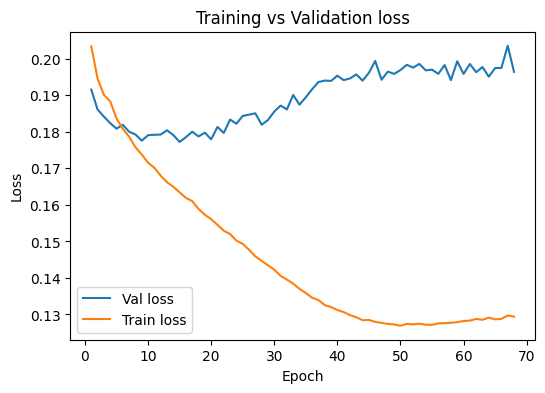

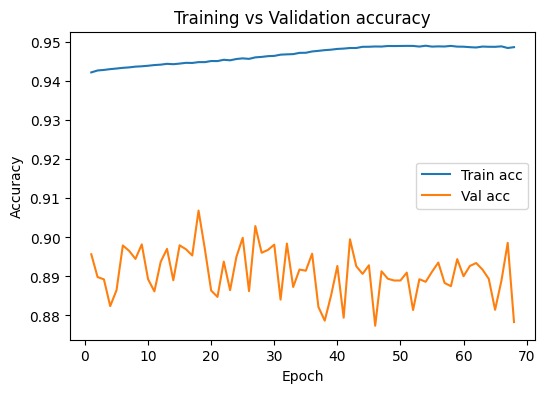

In [23]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
def to_float(x):
    if torch.is_tensor(x):
        return x.detach().cpu().item()
    return float(x)

val_vals   = [to_float(v) for v in val_losses]
train_vals = [to_float(v) for v in train_losses]

plt.plot(epochs_r, val_vals,   label='Val loss')
plt.plot(epochs_r, train_vals, label='Train loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation loss')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_r, train_accs, label='Train acc')
plt.plot(epochs_r, val_accs,  label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation accuracy')
plt.show()


In [24]:
# === 重新实例化网络，与训练时配置保持一致 ===
best_net = Net(config, num_classes).to(device)

# === 加载参数 ===
best_net.load_state_dict(torch.load(model_path, map_location=device))

best_net.eval()      # 切到推理模式（BN/Dropout 会自动关闭）



def pretty_print(split_name, metrics):
    acc, loss, prec, rec, f1, auc= metrics
    print(
        f"{split_name:<5} | "
        f"loss {loss:8.4f} | "
        f"acc {acc:6.4f} | "
        f"P {prec:6.4f} | "
        f"R {rec:6.4f} | "
        f"F1 {f1:6.4f}| "
        f"AUC {auc:6.4f}"
    )

# 评估
val_metrics  = evaluate(best_net, val_loader, threshold=best_threshold)
test_metrics = evaluate(best_net, test_loader, threshold=best_threshold)

# 打印
print("="*55)
pretty_print("VAL",  val_metrics)
pretty_print("TEST", test_metrics)
print("="*55)
# VAL   | loss   0.1969 | acc 0.9301 | P 0.3300 | R 0.2295 | F1 0.2707| AUC 0.8352
# TEST  | loss   0.2016 | acc 0.9290 | P 0.3336 | R 0.2165 | F1 0.2626| AUC 0.8299

/tmp/ipykernel_2817688/3853914457.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_net.load_state_dict(torch.load(model_path, map_location=device))


VAL   | loss   0.1819 | acc 0.8961 | P 0.2634 | R 0.4666 | F1 0.3367| AUC 0.8314
TEST  | loss   0.1841 | acc 0.8933 | P 0.2627 | R 0.4573 | F1 0.3337| AUC 0.8331
